In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('../msc-project/figstyle.mplstyle')
from matplotlib.font_manager import fontManager
fontManager.addfont('../msc-project/fonts/TIMES.TTF')
from pyrfu import pyrf
from matplotlib.cm import get_cmap
import logging
from scipy.optimize import curve_fit
import os
import csv
import numpy as np


Load IGRF coefficients ...


In [2]:

def filter_data(data_dict, **restrictions):
    """Filter data based on specified restrictions.

    Args:
        data_dict (np.recarray): The input dataset.
        restrictions (dict): Conditions as column_name=condition (e.g., beta_fit=lambda x: x >= 2).

    Returns:
        np.recarray: Filtered dataset.
    """
    mask = np.ones(len(data_dict), dtype=bool)
    s, e = pyrf.iso86012datetime64([data_dict.start, data_dict.end])
    duration = (e - s).astype('timedelta64[s]')
    duration_h = duration/np.timedelta64(1, 'h')

    for key, condition in restrictions.items():
        if key == "duration":
            mask &= condition(duration_h)
    
        else:
            mask &= condition(data_dict[key])
    
    return data_dict[mask], duration_h[mask]


def process_data(data_dict):
    minlen_h = 1
    filtered_data, durs = filter_data(
                data_dict,
                duration=lambda x: x >= minlen_h,
                pearsonr=lambda x: x >= 0,
                num_tot=lambda x:x > 0,
                ic = lambda x:x < 5,
                vsc_var = lambda x:x < 1e6,
                N_fit = lambda x:x < 1000
            
    )

    start = filtered_data.start
    end = filtered_data.end
    pearsonr = filtered_data.pearsonr
    N_fit = filtered_data.N_fit
    beta_fit_ = filtered_data.beta_fit
    num_tot = filtered_data.num_tot
    N_err = filtered_data.N_err
    beta_err = filtered_data.beta_err
    vsc_mean = filtered_data.vsc_mean
    vsc_median = filtered_data.vsc_median
    vsc_var = filtered_data.vsc_var
    ic = filtered_data.ic
    return filtered_data



def read_data(filepath, ic = 'all'):

    if type(ic) == str:
        sc = [1, 2, 3, 4]
    elif type(ic) == int:
        sc = [ic]
    
    data_out = []
    
    for i in sc:
        filepath_ = filepath.replace('?', str(i)) 
        try:
            print(f'Reading .csv file from {filepath_}...') 
            data_dict = np.genfromtxt(filepath_+'.csv', delimiter=',', names=True, skip_header=0, dtype=None)

            # Access columns by attributes (for example data_dict.start for start times)
            data_dict = data_dict.view(np.recarray)

            data_dict = process_data(data_dict)
        except FileNotFoundError:
            data_dict = 0
            
        data_out.append(data_dict)

    return data_out


In [3]:
# data_dict = np.genfromtxt('output_data_new_2/cal/stats/fitting_stats.csv', delimiter=',', names=True, skip_header=0, dtype=None)
data_dict = np.genfromtxt('output_data_new_2/stats/fitting_stats.csv', delimiter=',', names=True, skip_header=0, dtype=None)

data_dict = data_dict.view(np.recarray)

In [4]:
start_ = data_dict.start
end_ = data_dict.end
beta_ = data_dict.beta
N_ = data_dict.N0
ic_ = data_dict.ic
sw_mode_ = data_dict.sw_mode
vsc_mean_ = data_dict.vscmed
data_list = [start_, end_, beta_, N_, ic_, sw_mode_, vsc_mean_]


# Select data

In [5]:

def sel_ic(ic):
    filt_idx = (ic_ == ic) 

    data_list_filt = []
    for data in data_list:
        if type(data[0]) == np.float64 or type(data[0]) == np.int64:

            data[(np.abs(data) > 1e4) | (np.isnan(data))] = -10
        data_list_filt.append(data[filt_idx])
    
    return data_list_filt # start, end, beta, N, ic, sw_mode, vsc_mean

# Spatial distribution and length of intervals

In [6]:
data_compiled_tints = np.genfromtxt('sw_tints_new/compiled_sw_tints.csv', delimiter=',', names=True, skip_header=1,dtype=None)
data_compiled_tints_dict = {name: data_compiled_tints[name] for name in data_compiled_tints.dtype.names}
# read data with np.genfromtxt expecting the data to be (str, str, int, int)



In [7]:
start_compiled_tints, end_compiled_tints, ic_compiled_tints, sw_mode_compiled_tints = data_compiled_tints_dict.values()

14608


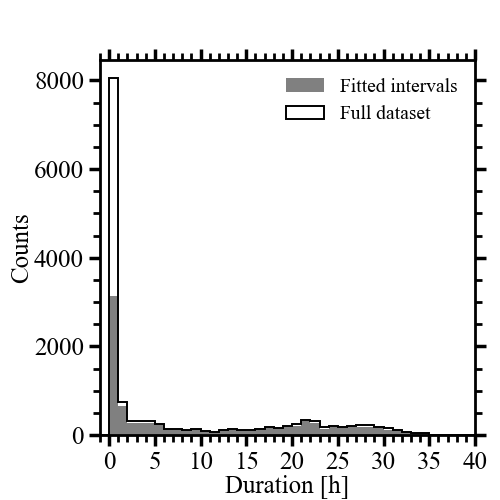

In [8]:
plt.close('all')
start_dt_compiled = pyrf.iso86012datetime64(start_compiled_tints)
end_dt_compiled  = pyrf.iso86012datetime64(end_compiled_tints)
tint_lens_compiled  = (end_dt_compiled  - start_dt_compiled ).astype('timedelta64[s]') / np.timedelta64(1, 'h')

start_dt = pyrf.iso86012datetime64(start_)
end_dt  = pyrf.iso86012datetime64(end_)
tint_lens = (end_dt  - start_dt ).astype('timedelta64[s]') / np.timedelta64(1, 'h')

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplots_adjust(left=0.2, right=0.95, top=0.99, bottom=0.02)
dmax = 40
print(len(start_dt_compiled ))
h2 = ax.hist(tint_lens, bins=np.arange(-1, dmax+1, 1), color='gray', linewidth=1.4, label='Fitted intervals')

h1 = ax.hist(tint_lens_compiled , bins=np.arange(-1, dmax+1, 1), color='k', edgecolor='k', histtype='step', linewidth=1.4, label='Full dataset')
ax.legend(loc='upper right', fontsize=14, frameon=False)
ax.set_xlabel('Duration [h]')
ax.set_ylabel('Counts')
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.set_box_aspect(1)
ax.set_xlim(-1, dmax)
fig.savefig('figures/thesis/duration_histogram.png',dpi=300)

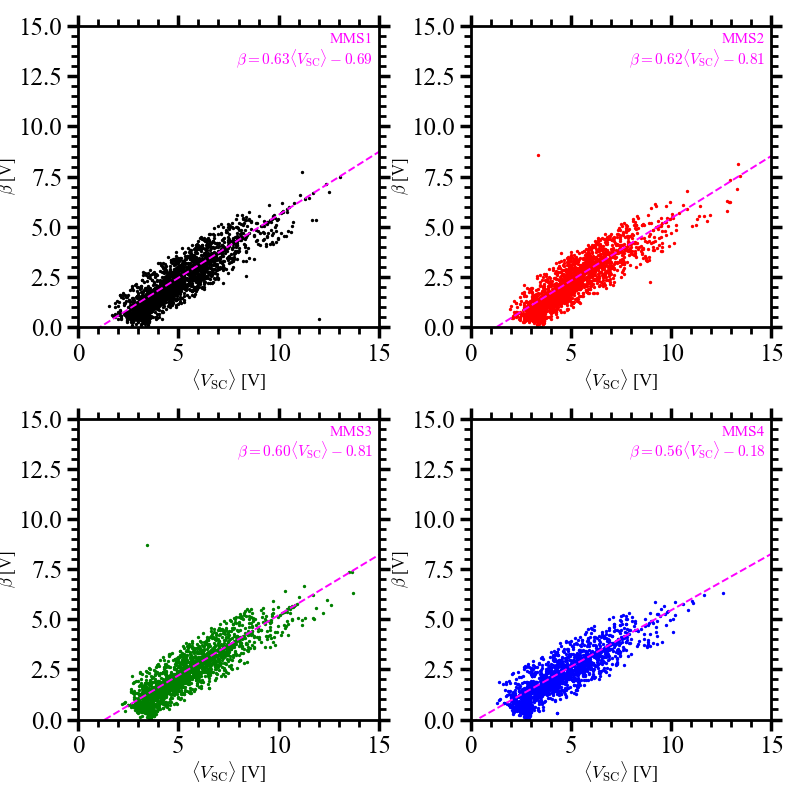

In [9]:
from scipy.stats import linregress


# read fitting parameters from csv file at 'output_data_new_2/cal/beta_vsc_cal.csv'
fit_params = np.genfromtxt('output_data_new_2/cal/beta_vsc_cal.csv', delimiter=',', skip_header=1, dtype=None)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))#, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
colors = ['black', 'red', 'green', 'blue']
for row in range(2):
    for col in range(2):
        ic_sel = row * 2 + col + 1
        ax = axs[row, col]
        start, end, beta, N, ic, sw_mode, vsc_mean = sel_ic(ic_sel)

        beta_cal, N0_cal = fit_params[ic_sel-1]

        ff = (vsc_mean < 20) & (beta < 20) & (beta >= 0)

        ax.scatter(vsc_mean[ff], beta[ff], s=2, color=colors[ic_sel-1])
        ax.set_xlim(0, 15)
        ax.set_ylim(0, 15)
        res = linregress(vsc_mean[ff], beta[ff])
        x = np.linspace(0, 20, 10)
        # ax.plot(x, res.slope * x + res.intercept, c='red', ls='--', lw=1.4)
        ax.plot(x, beta_cal * x + N0_cal, c='magenta', ls='--', lw=1.4)
        # make the y label beta and the x label vsc_mean
        ax.set_xlabel(r'$\langle V_\mathrm{SC} \rangle$ [V]', fontsize=13)
        ax.set_ylabel(r'$\beta$ [V]', fontsize=12)
        # display the equation of the line in the top right corner 
        ax.text(0.98, 0.98, f'MMS{ic_sel}', transform=ax.transAxes, fontsize=11,
                verticalalignment='top', horizontalalignment='right', color='magenta')
        ax.text(0.98, 0.93, fr'$\beta = {beta_cal:.2f} \langle V_\mathrm{{SC}} \rangle {str(np.sign(N0_cal))[0]} {np.abs(N0_cal):.2f}$', transform=ax.transAxes, fontsize=11,
                verticalalignment='top', horizontalalignment='right', color='magenta')
        ax.set_box_aspect(1)
        ax.grid(0)

fig.tight_layout()
fig.savefig('figures/thesis/beta_vsc_cal.png', dpi=300)


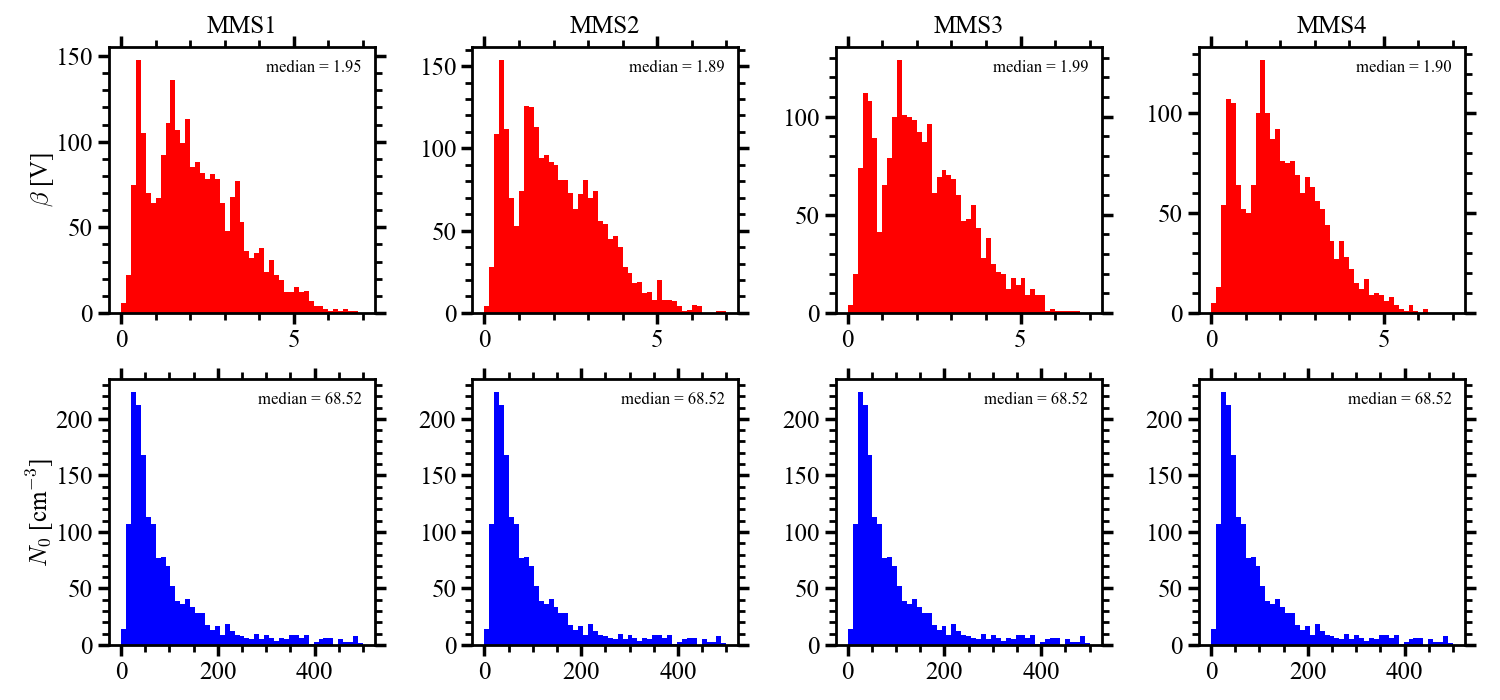

In [10]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15,7))
plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9, bottom=0.1, left=0.1, right=0.9)
nbins = 50
for row in range(2):
    for col in range(4):
        ax = axs[row, col]
        if row == 0:
            start, end, beta, N, ic, sw_mode, vsc_mean = sel_ic(col+1)
            ax.hist(beta, bins=np.linspace(0, 7, nbins), color='red')
            
            ax.set_title(f'MMS{col+1}')
            if col == 0: ax.set_ylabel(r'$\beta$ [V]')
        else:
            ax.hist(N, bins=np.linspace(0, 500, nbins), color='blue')
            if col == 0: ax.set_ylabel(r'$N_0$ [cm$^{-3}$]')
        
        # display the median of each distribution in the top right corner as a text
        median = np.median(beta) if row == 0 else np.median(N)
        ax.text(0.95, 0.95, f'median = {median:.2f}', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', horizontalalignment='right')
        
        ax.set_box_aspect(1)
        ax.grid(0)

fig.tight_layout()      
fig.savefig('figures/thesis/beta_N_distribution.png', dpi=300)

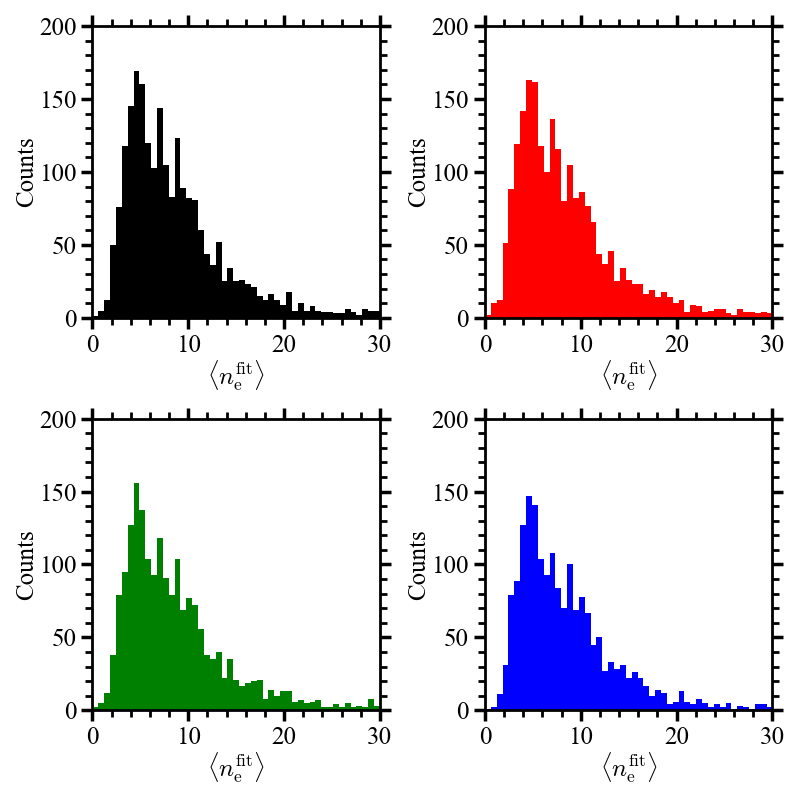

In [11]:
plt.close('all')
fig, axs = plt.subplots(2, 2, figsize=(8,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.9, bottom=0.1, left=0.1, right=0.9)
colors = ['black', 'red', 'green', 'blue']
for row in range(2):
    for col in range(2):
        ic_sel = row * 2 + col + 1
        ax = axs[row, col]
        start, end, beta, N, ic, sw_mode, vsc_mean = sel_ic(ic_sel)

        ne_mean = N*np.exp(-vsc_mean/beta)
        nbins= 50
        h = ax.hist(ne_mean, bins=np.linspace(0, 30, nbins), color=colors[ic_sel-1])
        ax.set_xlabel(r'$\langle n_\mathrm{e}^\mathrm{fit} \rangle$')# =N_0 \exp{\left(-\langle V_\mathrm{SC} \rangle / \beta \right)}$')
        # make major ticks every 5, minor ticks every 1
        ax.set_xlim(0, 30)
        ax.set_ylim(0, 200)
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
        ax.set_ylabel('Counts')
        ax.grid(0)

fig.tight_layout()
fig.savefig('figures/thesis/ne_mean_distribution.png', dpi=300)

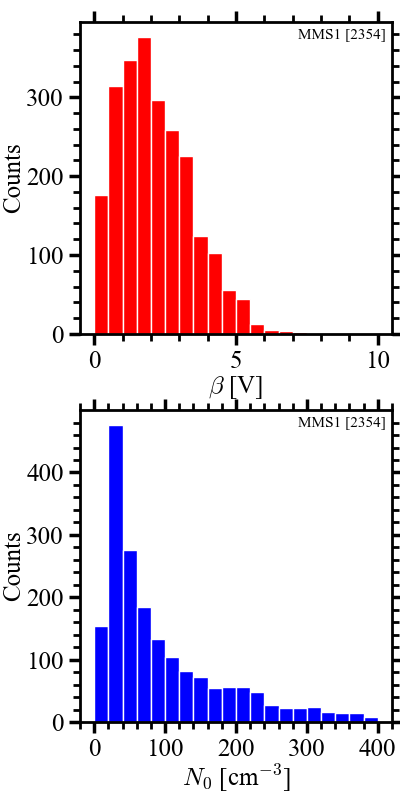

In [12]:
plt.close('all')
fig, axs = plt.subplots(nrows=2, figsize=(4, 8))
plt.subplots_adjust(top=0.98, bottom=0.09, left=0.2, right=0.98)
start, end, beta, N, ic, sw_mode, vsc_mean = sel_ic(1)

ax1, ax2 = axs
ax1.hist(beta, bins=np.linspace(0, 10, 21), color='red', edgecolor='white')
ax1.set_xlabel(r'$\beta$ [V]')
ax1.set_ylabel('Counts')

ax2.hist(N, bins=np.linspace(0, 400, 21), color='blue', edgecolor='white')
ax2.set_xlabel(r'$N_0$ [cm$^{-3}$]')
ax2.set_ylabel('Counts')
ax2.xaxis.set_major_locator(plt.MultipleLocator(100))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(20))
# ax3.hist(ne_mean, bins=np.linspace(0, 30, 50), color='black')
# ax3.set_xlabel(r'$\langle n_\mathrm{e}^\mathrm{fit} \rangle$')

# turn off grid for all axes
for ax in axs:
    ax.set_box_aspect(1)
    ax.grid(0)
    ax.text(0.98, 0.98, f'MMS1 {[len(N)]}', transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right', color='black')


# fig.tight_layout()
fig.savefig('figures/thesis/MMS1_beta_N_distribution.png', dpi=300)

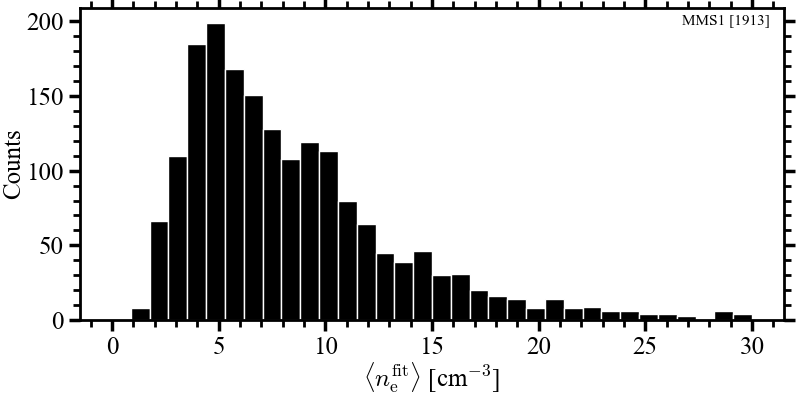

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 4))
plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.98, bottom=0.2, left=0.1, right=0.98)
start, end, beta, N, ic, sw_mode, vsc_mean = sel_ic(1)

ax.hist(ne_mean, bins=np.linspace(0, 30, 35), color='black', edgecolor='white')
ax.set_ylabel('Counts')
ax.set_xlabel(r'$\langle n_\mathrm{e}^\mathrm{fit} \rangle$ [cm$^{-3}$]')
# ax2.xaxis.set_major_locator(plt.MultipleLocator(100))
# ax2.xaxis.set_minor_locator(plt.MultipleLocator(20))

# ax.set_box_aspect(1)
ax.grid(0)
ax.text(0.98, 0.98, f'MMS1 {[len(ne_mean)]}', transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', color='black')

# fig.tight_layout()
fig.savefig('figures/thesis/MMS1_ne_mean_distribution.png', dpi=300)

In [14]:
from pyrfu import mms
from pyrfu.plot import plot_line, plot_spectr
import matplotlib.gridspec as gridspec
from ne2fpe import ne2fpe

In [20]:
# tint_example = ['2024-05-03T16:25:37.000000000', '2024-05-04T08:14:04.000000000']
tint_example = ['2024-05-03T16:25:37.000000000', '2024-05-04T08:09:04.000000000']

ic = 1
### READ DATA

# Electric field
# E_xyz_ = mms.get_data(f'e_gse_edp_fast_l2', tint_example, ic)

# Ion velocity
v_i_ = mms.get_data(f'vi_gse_fpi_fast_l2', tint_example, ic)

# Electron and ion densities
n_i_ = mms.get_data(f'ni_fpi_fast_l2', tint_example, ic)
n_e_ = mms.get_data(f'ne_fpi_fast_l2', tint_example, ic)

# Efield spectrum
epsd_ = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint_example)



# Spaceceraft potential
vsc_ = mms.get_data(f'v_edp_fast_l2', tint_example, ic)

# Remove duplicate points from pyrfu bug reading data across midnight (00:00:00)
# E_xyz = E_xyz_.drop_duplicates(dim='time')
v_i = v_i_.drop_duplicates(dim='time')
n_i = n_i_.drop_duplicates(dim='time')
n_e = n_e_.drop_duplicates(dim='time')
epsd = epsd_.drop_duplicates(dim='time')
vsc = vsc_.drop_duplicates(dim='time')


[29-May-25 09:41:10] INFO: Loading mms1_dis_bulkv_gse_fast...


[29-May-25 09:41:10] INFO: Loading mms1_dis_numberdensity_fast...
[29-May-25 09:41:10] INFO: Loading mms1_des_numberdensity_fast...
[29-May-25 09:41:10] INFO: Loading mms1_dsp_epsd_omni...
[29-May-25 09:41:10] INFO: Loading mms1_edp_scpot_fast_l2...


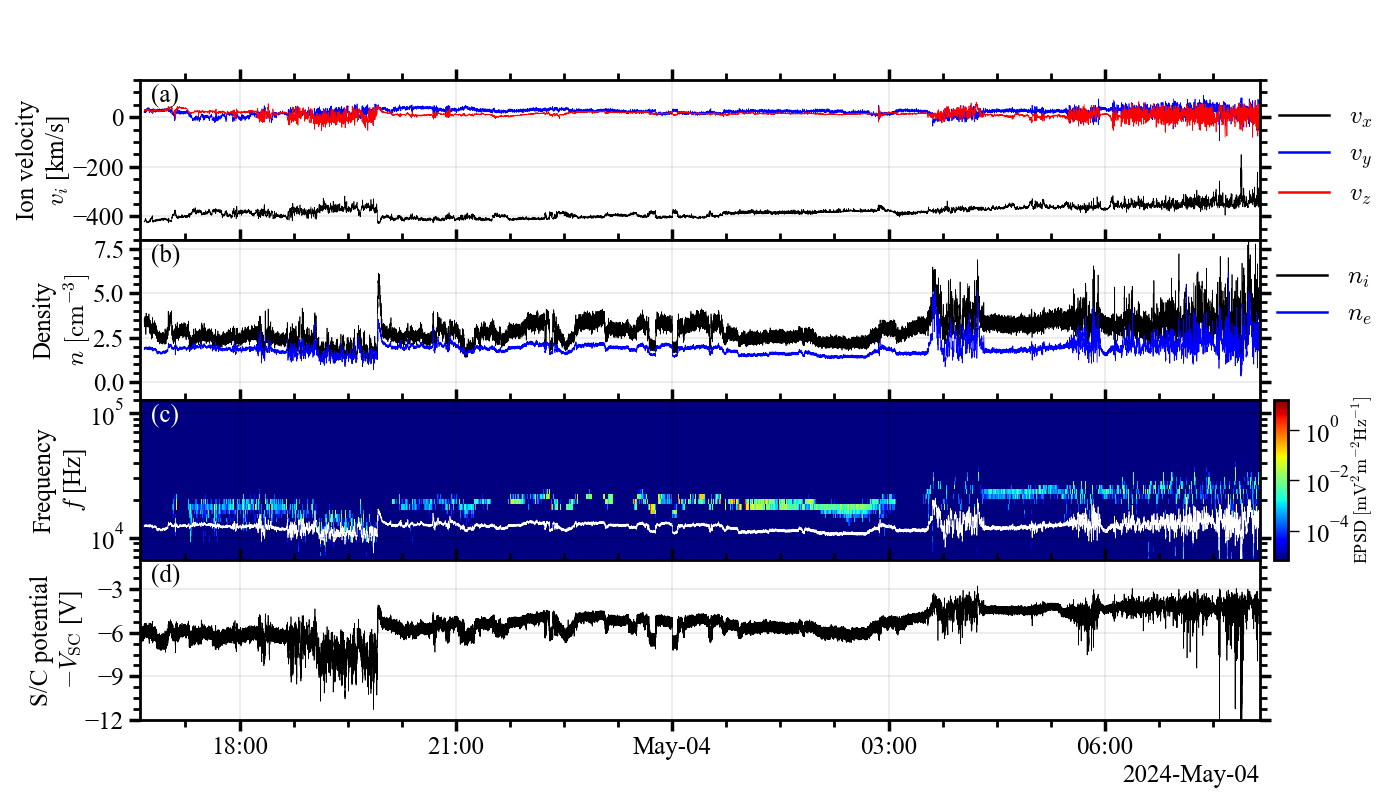

In [21]:
from cycler import cycler
### SET UP FIGURE AND SUBPLOT AXES
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
plt.close('all')
fig, axs = plt.subplots(nrows=4, figsize=(14, 8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.4, top=0.9, bottom=0.1, left=0.1, right=0.9)   

# Velocity, density, spectrum, vsc
ax_v=axs[0]
ax_n=axs[1]
ax_epsd=axs[2]
ax_vsc=axs[3]


### PLOT DATA

# Velocity
mycyc = cycler('color', ['k', 'b', 'r', 'g'])
plt.rc('axes', prop_cycle=mycyc)
# ax_v.set_prop_cycle()
plot_line(ax_v, v_i)
#ax_v.legend([r'$v_x$', r'$v_y$', r'$v_z$'], ncols=3, fontsize=13, loc='lower right')
# put a legend outside of the plot to the right touching the right edge with no background
ax_v.legend([r'$v_x$', r'$v_y$', r'$v_z$'], ncols=1, fontsize=18, loc='upper right', bbox_to_anchor=(1.12, 0.98), frameon=False)


ax_v.set_ylabel('Ion velocity\n'+r'$v_i$ [km/s]')
ax_v.set_ylim(-495, 150)

# Density
plot_line(ax_n, n_i)
plot_line(ax_n, n_e)
ax_n.set_ylabel('Density\n'+r'$n\ [\mathrm{cm^{-3}}]$')
ax_n.set_ylim(-1, 8)
# ax_n.legend([r'$n_i$', r'$n_e$'], ncols=2, fontsize=13)
ax_n.legend([r'$n_i$', r'$n_e$'], ncols=1, fontsize=18, loc='upper right', bbox_to_anchor=(1.12, 0.98), frameon=False)



# Efield spectrum
cmap = plt.cm.jet
cmap.set_bad('navy')
spectr_options = dict(yscale="log", cscale="log", cmap=cmap, grid=False)


# Convert spectral power from (V/m)^{2}/Hz -> (mV/m)^{2}/Hz
epsd.data *= 1e6
epsd.attrs['UNITS'] = '(mV/m)^{2}/Hz'

epsd_lim = epsd[:, 52:88]
epsd_sub = epsd_lim - np.median(epsd_lim, axis=0)
ax_spec, ax_cbar = plot_spectr(ax_epsd, epsd_sub, **spectr_options)

# Overlay f_pe from FPI
plot_line(ax_spec, ne2fpe(n_e), color='white')

ax_spec.set_ylabel('Frequency\n'+r'$f$ [Hz]')
ax_spec.grid(color='black')
ax_spec.set_ylim(6600, ax_spec.get_ylim()[1])
ax_spec.set_yticks([1e4, 1e5])

ax_cbar.grid(0)
ax_cbar.tick_params(axis='y', which='both',width=1)
ax_cbar.set_ylabel('EPSD '+r'$[\mathrm{mV^2 m^{-2}Hz^{-1}}]$', fontsize=13)




# Spacecraft potential
plot_line(ax_vsc, -vsc)
ax_vsc.set_ylabel('S/C potential\n'+r'$-V_\mathrm{SC}$ [V]')
ax_vsc.set_ylim(-12, -1)

for i, ax in enumerate(fig.axes):
    if i == 2:
        ax.text(0.01, 0.98, panel_labels[i], transform=ax.transAxes, fontsize=18, verticalalignment='top',color='white')
    elif i < 4:  
        ax.text(0.01, 0.98, panel_labels[i], transform=ax.transAxes, fontsize=18, verticalalignment='top', color='black')
    for line in ax.lines:
        line.set_linewidth(0.5)

fig.savefig('figures/thesis/overview.png', dpi=300)